In [1]:
import random
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
import numpy as np
import pickle
from joblib import Parallel, delayed
from math import log2, ceil
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.forest import LifelongClassificationForest
from proglearn.deciders import SimpleArgmaxAverage, KNNClassificationDecider
from proglearn.transformers import TreeClassificationTransformer, NeuralClassificationTransformer
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
from proglearn.sims import generate_gaussian_parity

C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\ten

In [2]:
def generate_gaussians_imbalance(n_samples=1000):
    X_xor, y_xor = generate_gaussian_parity(n_samples)
    X_xor_tmp = X_xor

    indices = np.where((y_xor==0))[0]
    to_replace = np.random.permutation(indices)[:int(indices.size * 0.9)]

    X_xor_imb = np.delete(X_xor, to_replace, axis=0)
    y_xor_imb = np.delete(y_xor, to_replace, axis=0)
    
    return X_xor, y_xor, X_xor_imb, y_xor_imb

[[-1.14355959  0.7394091 ]
 [-1.14355959  0.7394091 ]] [-1.14355959  0.7394091 ]
float64 float64


Text(0.5, 1.0, 'Gaussian XOR Class Imbalanced')

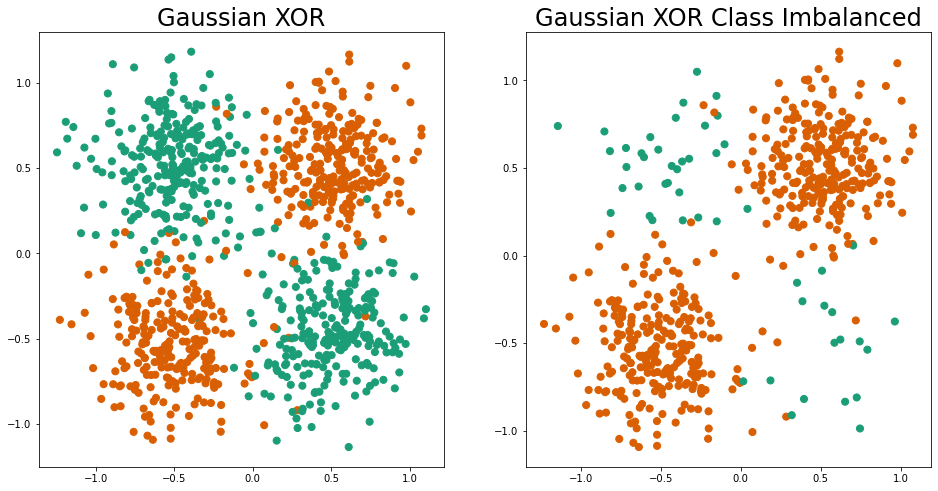

In [3]:
X_xor, y_xor = generate_gaussian_parity(n_samples=1000)
X_xor_tmp = X_xor

indices = np.where((y_xor==0))[0]
to_replace = np.random.permutation(indices)[:int(indices.size * 0.9)]

X_xor_imb = np.delete(X_xor, to_replace, axis=0)
y_xor_imb = np.delete(y_xor, to_replace, axis=0)

temp = np.where(X_xor == X_xor_tmp[~to_replace][0,:])[0]
print(X_xor[temp,:], X_xor_tmp[~to_replace][0,:])
print(X_xor.dtype, X_xor_tmp.dtype)

colors = sns.color_palette('Dark2', n_colors=2)

fig, ax = plt.subplots(1,2, figsize=(16,8))

clr = [colors[i] for i in y_xor]
clr_imb = [colors[i] for i in y_xor_imb]
ax[0].scatter(X_xor[:, 0], X_xor[:, 1], c=clr, s=50)
ax[1].scatter(X_xor_imb[:, 0], X_xor_imb[:, 1], c=clr_imb, s=50)

ax[0].set_title('Gaussian XOR', fontsize=24)
ax[1].set_title('Gaussian XOR Class Imbalanced', fontsize=24)

In [4]:
def experiment_BTE_imbalance(samples_task_1, samples_task_2, n_test, n_trees, max_depth, corr,
                   means_1, means_2,k_neighbors, acorn=None):
    
    # See if the sample sizes for both training sets are given.
    if samples_task_1 == 0 and samples_task_2 == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    # If acorn is specified, set random seed to it.
    if acorn != None:
        np.random.seed(acorn)

    # Initialize array for storing errors, task 1, and task 2.
    errors = np.zeros((len(means_2)+1), dtype=float)

    # Initialize the decider type and arguments.
    default_decider_class = KNNClassificationDecider
    default_decider_kwargs = {"classes" : np.arange(2), "k": k_neighbors}

    # Initialize the progressive learner using the transformer, voter and decider classes.
    LCF = LifelongClassificationForest(default_max_depth = max_depth)
    LCF.pl_.default_decider_class = default_decider_class
    LCF.pl_.default_decider_kwargs = default_decider_kwargs
    
    # Create the datasets with the Gaussian mean for task 1.
    _, _, X_task1, y_task1 = generate_gaussians_imbalance(samples_task_1)
    X_task1 = X_task1 - means_1
    _, _, test_task1, test_label_task1 = generate_gaussians_imbalance(n_test)
    test_task1 = test_task1 - means_1

    # Add a task for the task 1, predict the probabilities and add the MSE to the error array.
    LCF.add_task(X_task1, y_task1)
    predicted_Z1 = LCF.predict(test_task1, task_id=0)
    errors[0] = np.mean(predicted_Z1 == test_label_task1)

    # Then, add the transformer trained on task 2, predict and add the MSE to the error array.
    for i in range(len(means_2)):
        _, _, X_task2,y_task2 = generate_gaussians_imbalance(samples_task_2)
        X_task2 = X_task2 - means_2[0]

        LCF.add_transformer(X_task2, y_task2)
        predicted_transformer_Z1 = LCF.predict(test_task1, task_id=0)
        errors[i+1] = np.mean(predicted_transformer_Z1 == test_label_task1)
        
    return errors

In [5]:
# Set up the tree parameters.
mc_rep = 10
n_test = 100
n_trees = 10
n_sample_size = 1000
max_depth = 10

# Set up the data parameters.
corr = 0
means_1 = [(12,12)]
means_2 = [(-4,-4),(-3,-3),(-2,-2),(-1,-1),(0,0),(1,1),(2,2),(3,3),(4,4),
          (5,5),(6,6),(7,7),(8,8),(9,9),(10,10),(11,11),(12,12)]
k_neighbors = [3,5,9,17,33]

# Set up sample sizes.
samples_task_1 = 1000
samples_task_2 = 1000

In [6]:
# Initiate error arrays
mean_error_bte = np.zeros((len(k_neighbors), len(means_1) + len(means_2)))
std_error_bte = np.zeros((len(k_neighbors), len(means_1) + len(means_2)))

# Initiate transfer efficiency arrays
mean_bte = np.zeros((len(k_neighbors), len(means_1) + len(means_2)))

for i, n1 in enumerate(k_neighbors):
    # Create the error.
    error = np.array(
        Parallel(n_jobs=-1, verbose=1)(
            delayed(experiment_BTE_imbalance)(
                samples_task_1, samples_task_2, n_test, n_trees, 
                max_depth, corr, means_1[0], means_2, n1) for _ in range(mc_rep)
            )
        )

    mean_error_bte[i] = np.mean(error, axis=0)
    mean_bte[i] = mean_error_bte[i,0] / mean_error_bte[i]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 29.5min


KeyboardInterrupt: 

In [ ]:
def experiment_BTE_imbalance_SimpleAverage(samples_task_1, samples_task_2, n_test, n_trees, max_depth, corr,
                   means_1, means_2, acorn=None):
    
    # See if the sample sizes for both training sets are given.
    if samples_task_1 == 0 and samples_task_2 == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    # If acorn is specified, set random seed to it.
    if acorn != None:
        np.random.seed(acorn)

    # Initialize array for storing errors, task 1, and task 2.
    errors = np.zeros((len(means_2)+1), dtype=float)

    # Initialize the lifelongClassificationForest using the transformer, voter and decider classes.
    LCF = LifelongClassificationForest(default_max_depth = max_depth)
    
    # Create the datasets with the Gaussian mean for task 1.
    _, _, X_task1, y_task1 = generate_gaussians_imbalance(samples_task_1)
    X_task1 = X_task1 - means_1

    _, _, test_task1, test_label_task1 = generate_gaussians_imbalance(n_test)
    test_task1 = test_task1 - means_1

    # Add a task for the task 1, predict the probabilities and add the MSE to the error array.
    LCF.add_task(X_task1, y_task1)
    predicted_Z1 = LCF.predict(test_task1, task_id=0)
    errors[0] = np.mean(predicted_Z1 == test_label_task1)
   
    # Then, add the transformer trained on task 2, predict and add the MSE to the error array.
    for i in range(len(means_2)):
        _, _, X_task2,y_task2 = generate_gaussians_imbalance(samples_task_2)
        X_task2 = X_task2 - means_2[0]
        
        LCF.add_transformer(X_task2, y_task2)
        predicted_transformer_Z1 = LCF.predict(test_task1, task_id=0)
        errors[i+1] = np.mean(predicted_transformer_Z1 == test_label_task1)
        
    return errors

In [ ]:
# Initiate error arrays
mean_error_bte_imbalanced_SimpleAverage = np.zeros((1, len(means_1) + len(means_2)))
std_error_bte_imbalanced_SimpleAverage = np.zeros((1, len(means_1) + len(means_2)))

# Initiate transfer efficiency arrays
mean_bte_imbalanced_SimpleAverage = np.zeros((1, len(means_1) + len(means_2)))

# Create the error.
error = np.array(
    Parallel(n_jobs=-1, verbose=1)(
        delayed(experiment_BTE_imbalance_SimpleAverage)(
            samples_task_1, samples_task_2, n_test, n_trees, 
            max_depth, corr, means_1[0], means_2) for _ in range(mc_rep)
        )
    )

mean_error_bte_imbalanced_SimpleAverage = np.mean(error, axis=0)
mean_bte_imbalanced_SimpleAverage[0] = mean_error_bte_imbalanced_SimpleAverage[0] / mean_error_bte_imbalanced_SimpleAverage

In [ ]:
# Create empty Euclidean distance.
ran = np.arange((mean_bte).shape[1])
labels = ['k=3','k=5','k=9','k=17','k=33', 'SimpleAverage']

# Plot the BTEs
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(ran, mean_bte[0], ls="-", lw=2, marker='o')
ax.plot(ran, mean_bte[1], ls="-", lw=2, marker='o')
ax.plot(ran, mean_bte[2], ls="-", lw=2, marker='o')
ax.plot(ran, mean_bte[3], ls="-", lw=2, marker='o')
ax.plot(ran, mean_bte[4], ls="-", lw=2, marker='o')
ax.plot(ran, mean_bte_imbalanced_SimpleAverage[0], lw=2, marker='x')

ax.set_ylabel("Backward Transfer Efficiency wrt Task 1", fontsize=20)
ax.legend(labels, loc="upper left", fontsize=16, frameon=True)
ax.set_xlabel("Task Number", fontsize=20)
ax.axvline(x=0, c="gray", linewidth=1.5, linestyle="dashed")
ax.axhline(y=1, c="gray", linewidth=1.5, linestyle="dashed")
ax.set_xticks(ran)
ax.set_title('Setting 2: Imbalance', fontsize=20)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)
plt.tight_layout()

In [ ]:
def experiment_BTE_balance(samples_task_1, samples_task_2, n_test, n_trees, max_depth, corr,
                   means_1, means_2,k_neighbors, acorn=None):
    
    # See if the sample sizes for both training sets are given.
    if samples_task_1 == 0 and samples_task_2 == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    # If acorn is specified, set random seed to it.
    if acorn != None:
        np.random.seed(acorn)

    # Initialize array for storing errors, task 1, and task 2.
    errors = np.zeros((len(means_2)+1), dtype=float)

    # Initialize the decider type and arguments.
    default_decider_class = KNNClassificationDecider
    default_decider_kwargs = {"classes" : np.arange(2), "k": k_neighbors}

    # Initialize the progressive learner using the transformer, voter and decider classes.
    LCF = LifelongClassificationForest(default_max_depth = max_depth)
    LCF.pl_.default_decider_class = default_decider_class
    LCF.pl_.default_decider_kwargs = default_decider_kwargs
    
    # Create the datasets with the Gaussian mean for task 1.
    X_task1, y_task1, _, _ = generate_gaussians_imbalance(samples_task_1)
    X_task1 = X_task1 - means_1
    test_task1, test_label_task1, _, _ = generate_gaussians_imbalance(n_test)
    test_task1 = test_task1 - means_1

    # Add a task for the task 1, predict the probabilities and add the MSE to the error array.
    LCF.add_task(X_task1, y_task1)
    predicted_Z1 = LCF.predict(test_task1, task_id=0)
    errors[0] = np.mean(predicted_Z1 == test_label_task1)

    # Then, add the transformer trained on task 2, predict and add the MSE to the error array.
    for i in range(len(means_2)):
        X_task2,y_task2, _, _  = generate_gaussians_imbalance(samples_task_2)
        X_task2 = X_task2 - means_2[0]

        LCF.add_transformer(X_task2, y_task2)
        predicted_transformer_Z1 = LCF.predict(test_task1, task_id=0)
        errors[i+1] = np.mean(predicted_transformer_Z1 == test_label_task1)
        
    return errors

In [ ]:
# Initiate error arrays
mean_error_bte_balance = np.zeros((len(k_neighbors), len(means_1) + len(means_2)))
std_error_bte_balance = np.zeros((len(k_neighbors), len(means_1) + len(means_2)))

# Initiate transfer efficiency arrays
mean_bte_balance = np.zeros((len(k_neighbors), len(means_1) + len(means_2)))

for i, n1 in enumerate(k_neighbors):
    # Create the error.
    error = np.array(
        Parallel(n_jobs=-1, verbose=1)(
            delayed(experiment_BTE_balance)(
                samples_task_1, samples_task_2, n_test, n_trees, 
                max_depth, corr, means_1[0], means_2, n1) for _ in range(mc_rep)
            )
        )

    mean_error_bte_balance[i] = np.mean(error, axis=0)
    mean_bte_balance[i] = mean_error_bte_balance[i,0] / mean_error_bte_balance[i]

In [ ]:
def experiment_BTE_balanced_SimpleAverage(samples_task_1, samples_task_2, n_test, n_trees, max_depth, corr,
                   means_1, means_2, acorn=None):
    
    # See if the sample sizes for both training sets are given.
    if samples_task_1 == 0 and samples_task_2 == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    # If acorn is specified, set random seed to it.
    if acorn != None:
        np.random.seed(acorn)

    # Initialize array for storing errors, task 1, and task 2.
    errors = np.zeros((len(means_2)+1), dtype=float)

    # Initialize the lifelongClassificationForest using the transformer, voter and decider classes.
    LCF = LifelongClassificationForest(default_max_depth = max_depth)
    
    # Create the datasets with the Gaussian mean for task 1.
    X_task1, y_task1, _, _ = generate_gaussians_imbalance(samples_task_1)
    X_task1 = X_task1 - means_1

    test_task1, test_label_task1, _, _ = generate_gaussians_imbalance(n_test)
    test_task1 = test_task1 - means_1

    # Add a task for the task 1, predict the probabilities and add the MSE to the error array.
    LCF.add_task(X_task1, y_task1)
    predicted_Z1 = LCF.predict(test_task1, task_id=0)
    errors[0] = np.mean(predicted_Z1 == test_label_task1)
   
    # Then, add the transformer trained on task 2, predict and add the MSE to the error array.
    for i in range(len(means_2)):
        X_task2,y_task2, _, _ = generate_gaussians_imbalance(samples_task_2)
        X_task2 = X_task2 - means_2[0]
        
        LCF.add_transformer(X_task2, y_task2)
        predicted_transformer_Z1 = LCF.predict(test_task1, task_id=0)
        errors[i+1] = np.mean(predicted_transformer_Z1 == test_label_task1)
        
    return errors

In [ ]:
# Initiate error arrays
mean_error_bte_balanced_SimpleAverage = np.zeros((1, len(means_1) + len(means_2)))
std_error_bte_balanced_SimpleAverage = np.zeros((1, len(means_1) + len(means_2)))

# Initiate transfer efficiency arrays
mean_bte_balanced_SimpleAverage = np.zeros((1, len(means_1) + len(means_2)))

# Create the error.
error = np.array(
    Parallel(n_jobs=-1, verbose=1)(
        delayed(experiment_BTE_balanced_SimpleAverage)(
            samples_task_1, samples_task_2, n_test, n_trees, 
            max_depth, corr, means_1[0], means_2) for _ in range(mc_rep)
        )
    )

mean_error_bte_balanced_SimpleAverage = np.mean(error, axis=0)
mean_bte_balanced_SimpleAverage[0] = mean_error_bte_balanced_SimpleAverage[0] / mean_error_bte_balanced_SimpleAverage

In [ ]:
# Create empty Euclidean distance.
ran = np.arange((mean_bte_balance).shape[1])
labels = ['k=3','k=5','k=9','k=17','k=33','SimpleAverage']

# Plot the BTEs
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(ran, mean_bte_balance[0], ls="-", lw=2, marker='o')
ax.plot(ran, mean_bte_balance[1], ls="-", lw=2, marker='o')
ax.plot(ran, mean_bte_balance[2], ls="-", lw=2, marker='o')
ax.plot(ran, mean_bte_balance[3], ls="-", lw=2, marker='o')
ax.plot(ran, mean_bte_balance[4], ls="-", lw=2, marker='o')
ax.plot(ran, mean_bte_balanced_SimpleAverage[0], ls="-", lw=3, marker='x')

ax.set_ylabel("Backward Transfer Efficiency wrt Task 1", fontsize=20)
ax.legend(labels, loc="upper left", fontsize=16, frameon=True)
ax.set_xlabel("Task Number", fontsize=20)
ax.axvline(x=0, c="gray", linewidth=1.5, linestyle="dashed")
ax.axhline(y=1, c="gray", linewidth=1.5, linestyle="dashed")
ax.set_xticks(ran)
ax.set_title('Setting 2: Balanced', fontsize=20)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)
plt.tight_layout()